# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь встраивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

In [1]:
from __future__ import print_function
import argparse
import importlib
import os
import pickle
import sys

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple
from tqdm import tqdm
from sklearn.metrics import average_precision_score

from ssd import SSD
import pickle
import tensorflow as tf
from PIL import Image

In [3]:
plt.rcParams["figure.figsize"] = [10., 7.]

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [16]:
sys.path.insert(1, 'train')

In [17]:
import provider
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
from train_util import get_batch

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

## Некоторые функции

In [5]:
def car2cam(path):
    P2 = None
    R0_rect = None
    Tr_velo_to_cam = None
    with open(path) as f:
        raw = f.read()
        raw = raw[:-2].split('\n')
        P2_vals = np.array(list(map(float, raw[2].split()[1:])))
        P2 = P2_vals.reshape(3, 4)
        
        R0_vals = np.array(list(map(float, raw[4].split()[1:])))
        R0_rect = np.zeros((4, 4))
        R0_rect[3, 3] = 1
        R0_rect[:3, :3] = R0_vals.reshape(3, 3)
        
        Tr_vals = np.array(list(map(float, raw[5].split()[1:])))
        Tr_velo_to_cam = np.zeros((4, 4))
        Tr_velo_to_cam[3, 3] = 1
        Tr_velo_to_cam[:3, :4] = Tr_vals.reshape(3, 4)
        
    return P2, R0_rect, Tr_velo_to_cam

In [6]:
def points_in_box(box, points):
    y_test = (box[0] <= points[:,1]) * (box[2] >= points[:,1])
    x_test = (box[1] <= points[:,0]) * (box[3] >= points[:,0])
    return x_test * y_test

In [7]:
def get_session_and_ops(model, batch_size, num_point):
    """ Define model graph, load model parameters,
    create session and return session handle and tensors
    """
    with tf.Graph().as_default():
        with tf.device('/gpu:0'):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                model.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = model.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, 'train/log_v1/model.ckpt')
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

In [8]:
def inference(sess, ops, pc, one_hot_vec, batch_size):
    """ Run inference for frustum pointnets in batch mode """
    assert pc.shape[0] % batch_size == 0
    num_batches = int(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], 2))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], 12))
    heading_residuals = np.zeros((pc.shape[0], 12))
    size_logits = np.zeros((pc.shape[0], 8))
    size_residuals = np.zeros((pc.shape[0], 8, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        feed_dict = { \
            ops['pointclouds_pl']: pc[i * batch_size:(i + 1) * batch_size, ...],
            ops['one_hot_vec_pl']: one_hot_vec[i * batch_size:(i + 1) * batch_size, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[i * batch_size:(i + 1) * batch_size, ...] = batch_logits
        centers[i * batch_size:(i + 1) * batch_size, ...] = batch_centers
        heading_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_scores
        heading_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_residuals
        size_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_size_scores
        size_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_size_residuals

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res

In [9]:
def get_angle(box, P):
    box2d_center = np.array([(box[1]+box[3])/2.0, (box[0]+box[1])/2.0])
    uv_depth = np.zeros((1,3))
    uv_depth[0,0:2] = box2d_center
    uv_depth[0,2] = 20 # some random depth
    
    
    c_u = P[0,2]
    c_v = P[1,2]
    f_u = P[0,0]
    f_v = P[1,1]
    b_x = P[0,3]/(-f_u) # relative 
    b_y = P[1,3]/(-f_v)
   
    
    n = uv_depth.shape[0]
    x = ((uv_depth[:,0]-c_u)*uv_depth[:,2])/f_u + b_x
    y = ((uv_depth[:,1]-c_v)*uv_depth[:,2])/f_v + b_y
    box2d_center_rect = np.zeros((n,3))
    box2d_center_rect[:,0] = x
    box2d_center_rect[:,1] = y
    box2d_center_rect[:,2] = uv_depth[:,2]
    frustum_angle = -1 * np.arctan2(box2d_center_rect[0,2], box2d_center_rect[0,0])
    return frustum_angle

In [10]:
Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

In [70]:
def bbox_to_vertices(bbox):
    bbox = bbox.reshape(2, 2)
    return np.array([bbox[0], [bbox[0, 0], bbox[1, 1]], bbox[1], [bbox[1, 0], bbox[0, 1]], bbox[0]])

In [91]:
def plot_boxes(im, boxes, projs, rs):
    plt.figure(figsize=(15, 5))
    plt.imshow(im)
    for box in boxes:
        vertices = bbox_to_vertices(box)
        plt.plot(vertices[:, 1], vertices[:, 0], c='g')
    for proj, r in zip(projs, rs):
        plt.scatter(proj[:, 0], proj[:, 1], c=np.log1p(r), s=1)
    plt.show()

## pipeline

In [115]:
class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.frustrum_pointnet = frustum_pointnet
        self.frustrum_bs = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_thr = ssd_threshold
    
    def predict(self, xyz, image, car_to_cam, intrinsics, sess=None, plot=True):
        P2, R0_rect, Tr_velo_to_cam = car_to_cam
        xyz2image = (P2 @ R0_rect @ Tr_velo_to_cam).T
        xyz2xyz = (R0_rect @ Tr_velo_to_cam).T
        r = np.linalg.norm(xyz[:, :2], axis=1)
        
        # project xyz into image
        xyzh = xyz.copy()
        xyzh[:, 3] = 1
        
        proj = xyzh @ xyz2image
        proj = proj[:, :2] / proj[:, 2:]
        
        # transform xyz (same way as in prepare data)
        xyzf = xyzh.copy()
        xyzf = xyzf @ xyz2xyz
        xyzf[:, 3] = xyz[:, 3]
        
        # mask for points in image
        in_im = points_in_box([0, 0, image.shape[0], image.shape[1]], proj)
        
        #get sess and ops
        if sess is None:
            sess, ops = get_session_and_ops(self.frustrum_pointnet, batch_size=1, num_point=1024)
        else:
            sess, ops = sess
        
        # TODO: run 2D detector on the image
        ssd_res = self.ssd_detector.predict(image)
        boxes = ssd_res["detection_boxes"][:ssd_res['num_detections']]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * image.shape[0]
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * image.shape[1]
        scores = ssd_res["detection_scores"][:ssd_res['num_detections']]
        classes = ssd_res["detection_classes"][:ssd_res['num_detections']]
        
        
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        boxes = boxes[(classes == 1) * (scores > self.ssd_thr)]
        scores = scores[(classes == 1) * (scores > self.ssd_thr)]
        # TODO: process lidar point cloud and construct frustum examples
       
        frustrums = []
        angles = []
        
        projs = []
        rs = []
        
        for box in boxes:
            ind = points_in_box(box, proj)
            pc = xyzf[ind * in_im]
            
            projs.append(proj[ind * in_im])
            rs.append(r[ind * in_im])
            
            frustrums.append(pc[np.random.choice(pc.shape[0], 1024)].reshape(1, 1024, 4))
            angles.append(get_angle(box, P2))
#         frustrums = np.vstack(frustrums)   
        if plot:
            plot_boxes(image, boxes, projs, rs)
            
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        results = []
        one_hot = np.zeros((1, 3))
        one_hot[:,0] = 1
        for i in range(len(frustrums)):
            batch_output, batch_center_pred, \
            batch_hclass_pred, batch_hres_pred, \
            batch_sclass_pred, batch_sres_pred = inference(sess, ops, 
                                                           frustrums[i], 
                                                           one_hot, 
                                                           batch_size=1)
            
            
            h,w,l,tx,ty,tz,ry = provider.from_prediction_to_label_format(batch_center_pred[0],
            batch_hclass_pred[0], batch_hres_pred[0],
            batch_sclass_pred[0], batch_sres_pred[0], angles[i])
            detec = Detection(xyz=np.array([tx, ty, tz]), 
                              angle=ry, 
                              lwh=np.array([l, w, h]), 
                              confidence=scores[i])
            results.append(detec)
        # TODO: construct Scene namedtuple and return it
        scene = Scene(results)
        return scene
    

# test

In [101]:
img = '000101'

In [102]:
model = importlib.import_module('frustum_pointnets_v1')
detector = SSD('tmp')
im =  np.array(Image.open(f'training/image_2/{img}.png'))
car_to_cam = car2cam(f'training/calib/{img}.txt')
xyzi = np.fromfile(f'training/velodyne/{img}.bin', dtype=np.float32).reshape(-1, 4)
sess = get_session_and_ops(model, batch_size=1, num_point=1024)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from train/log_v1/model.ckpt


In [116]:
pipe = PipelineDetector(model, 1, detector, 0.9)

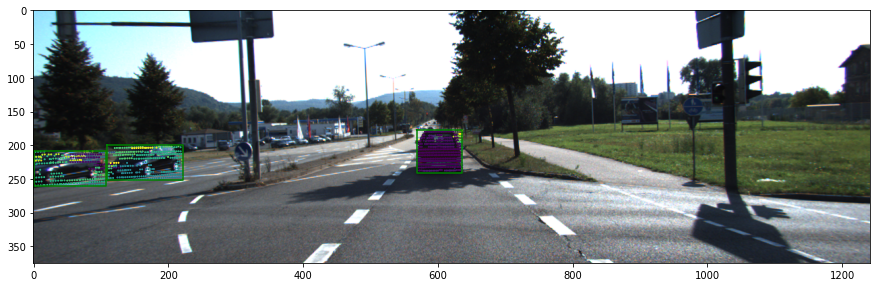

In [117]:
res = pipe.predict(xyzi, im, car_to_cam, None, sess=sess)

In [118]:
res.detections[0]

Detection(xyz=array([-6.54391878,  2.16240797, -6.86919816]), angle=-4.862571956585583, lwh=array([4.46830366, 1.60780614, 1.75901599]), confidence=1.0)

In [119]:
res.detections[1]

Detection(xyz=array([-4.93630174,  2.01536733, -7.77418837]), angle=-5.011574817296671, lwh=array([4.71672533, 1.59414786, 1.93897928]), confidence=1.0)

In [120]:
res.detections[2]

Detection(xyz=array([-19.57563655,   1.69098161,  -0.45792682]), angle=-3.159518081446264, lwh=array([3.69990733, 1.65745297, 1.55542262]), confidence=1.0)

In [121]:
with open(f'training/label_2/{img}.txt') as f:
    print(f.read())

Car 0.00 0 -1.56 569.23 177.21 636.06 240.52 1.55 1.63 3.32 -0.22 1.68 19.47 -1.57
Car 0.30 3 2.22 0.00 212.95 108.77 265.03 1.40 1.85 4.11 -19.15 2.85 24.13 1.56
Car 0.00 0 2.09 106.33 200.09 220.09 253.47 1.62 1.85 3.57 -15.54 2.63 25.25 1.54
DontCare -1 -1 -10 271.74 189.55 290.90 207.21 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 227.76 196.19 243.41 207.05 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 333.14 186.07 440.44 199.00 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 292.90 188.56 322.11 203.19 -1 -1 -1 -1000 -1000 -1000 -10



## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [1846]:
def get_pred_boxes(scene):
    boxes = []
    scores = []
    for detec in scene.detections:
        lx, ly = detec.xyz[0], detec.xyz[1]
        rx, ry = lx + detec.lwh[0], ly + detec.lwh[1]
        boxes.append(np.array([lx, ly, rx, ry]))
        scores.append(detec.confidence)
    return np.vstack((boxes)), np.array(scores)

In [1910]:
def get_gt_boxes(img):
    boxes = []
    with open(f'training/label_2/{img}.txt') as f:
        for l in f.readlines():
            data = l.split()
            if data[0] == "Car":
                x, y, l, w = 
                box = list(map(float, [data[4], data[5], data[6], data[7]]))
                boxes.append(box)
    if len(boxes) == 0:
        return None
    return np.vstack((boxes))

In [1862]:
def iou(bboxes1, bboxes2):
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [1840]:
model = importlib.import_module('frustum_pointnets_v1')
detector = SSD('tmp')
im =  np.array(Image.open(f'training/image_2/{img}.png'))
car_to_cam = car2cam(f'training/calib/{img}.txt')
xyzi = np.fromfile(f'training/velodyne/{img}.bin', dtype=np.float32).reshape(-1, 4)
sess = get_session_and_ops(model, batch_size=1, num_point=1024)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from train/log_v1/model.ckpt


In [1893]:
model = importlib.import_module('frustum_pointnets_v1')
sess = get_session_and_ops(model, batch_size=1, num_point=1024)
pipe = PipelineDetector(model, 1, detector, 0)
img_dir = os.listdir('training/image_2')

In [1912]:
corr = None
scores = None

In [1914]:
for img_name in img_dir:
    img = img_name.split('.')[0]
    im =  np.array(Image.open(f'training/image_2/{img}.png'))
    car_to_cam = car2cam(f'training/calib/{img}.txt')
    xyzi = np.fromfile(f'training/velodyne/{img}.bin', dtype=np.float32).reshape(-1, 4)
    
    
    res = pipe.predict(xyzi, im, car_to_cam, None, sess=sess)
    if len(res.detections) == 0:
        continue
    preds, cur_scores = get_pred_boxes(res)
    gts = get_gt_boxes(img)
    if gts is None:
        continue
    ious = iou(preds, gts)
    inds = np.argmax(ious, axis=1)
    best_ious = ious[np.arange(preds.shape[0]), inds]
    cur_corr = (best_ious > 0.7).astype(int)
    
    if corr is None:
        corr = cur_corr
        scores = cur_scores
    else:
        corr = np.hstack((corr, cur_corr))
        scores = np.hstack((scores, cur_scores))
    

In [1922]:
def average_precision(corr, scores):
    ind = np.argsort(scores)
    corr = corr[ind]
    TP = np.cumsum(corr)
    TP_plus_FP = np.arange(1, len(corr) + 1)
    acc = TP / TP_plus_FP
    return np.mean(acc)

In [1923]:
average_precision(corr, scores)

0.0

In [1924]:
from IPython.display import Image as Im

In [1925]:
Im(url='https://wompampsupport.azureedge.net/fetchimage?siteId=7575&v=2&jpgQuality=100&width=700&url=https%3A%2F%2Fi.kym-cdn.com%2Fentries%2Ficons%2Ffacebook%2F000%2F028%2F021%2Fwork.jpg')